In [5]:
# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt
# import cv2
# import os
# import easyocr
# import fitz  # PyMuPDF
# import re
# from PIL import Image
# from image_cropping import crop_and_save_shooting_side_and_map_from_folder, crop_and_save_avg_formation_from_folder
# from generate_graph import process_folder_with_fixed_pixel_grid, scale_mask, plot_heatmap, extract_xg_value, extract_attempts, extract_stats_from_image, process_folder_attack_side, plot_attack_side, extract_image_data,process_table_data, avg_formation_from_folder, plot_avg_formation 
# from helper import find_team_folder, remove_pdfs_with_northwestern
# from generate_prompt import get_team_data, generate_prompt
from player_recommend import calculate_weighted_scores, get_most_played_position, get_opponent, plot_pitch_from_dataframe

In [7]:
team_name = "Penn State"
other_team_name = "Penn State Nittany Lion"
team_data_path = "../team-data/big-ten-combined-data.csv"
match_reports_path = "../match-reports"

play_year = 2024
player_data_path = "../../player-data/player-combined-data.csv"

In [3]:
try:
    folder_path = find_team_folder(team_name, match_reports_path)
    if folder_path:
        remove_pdfs_with_northwestern(folder_path)
        print("Matching folder path:", folder_path)
    else:
        print("No matching folder found.")
except FileNotFoundError as e:
    print(e)  

Matching folder path: ../match-reports/penn-state-2024


In [4]:
crop_and_save_shooting_side_and_map_from_folder(folder_path, team_name)
crop_and_save_avg_formation_from_folder(folder_path, team_name)

Cropped image saved as ../match-reports/penn-state-2024/home_team/shooting_map/shooting_map_1_Penn State_against_Rutgers Scarlet Knights 2.png
Cropped image saved as ../match-reports/penn-state-2024/home_team/shooting_side/shooting_side_1_Penn State_against_Rutgers Scarlet Knights 2.png
Cropped image saved as ../match-reports/penn-state-2024/opp_team/shooting_map/shooting_map_1_Rutgers Scarlet Knights 2_against_Penn State.png
Cropped image saved as ../match-reports/penn-state-2024/opp_team/shooting_side/shooting_side_1_Rutgers Scarlet Knights 2_against_Penn State.png
Cropped image saved as ../match-reports/penn-state-2024/home_team/shooting_map/shooting_map_2_Penn State_against_St John's Red Storm.png
Cropped image saved as ../match-reports/penn-state-2024/home_team/shooting_side/shooting_side_2_Penn State_against_St John's Red Storm.png
Cropped image saved as ../match-reports/penn-state-2024/opp_team/shooting_map/shooting_map_2_St John's Red Storm_against_Penn State.png
Cropped image 

Cropped image saved as ../match-reports/penn-state-2024/home_team/avg_formation/avg_formation_4_Maryland College Park Terrapins_Penn State Nittany Lion 1.png
Cropped image saved as ../match-reports/penn-state-2024/home_team/avg_formation/avg_formation_5_Penn State Nittany Lion_Michigan State Spartans 2.png
Cropped image saved as ../match-reports/penn-state-2024/home_team/avg_formation/avg_formation_6_Indiana Hoosiers_Penn State Nittany Lion 2.png
Cropped image saved as ../match-reports/penn-state-2024/home_team/avg_formation/avg_formation_7_Penn State Nittany Lion_Wisconsin Badgers 0.png
Cropped image saved as ../match-reports/penn-state-2024/home_team/avg_formation/avg_formation_8_Penn State Nittany Lion_Ohio State Buckeyes 0.png
Cropped image saved as ../match-reports/penn-state-2024/home_team/avg_formation/avg_formation_9_Penn State Nittany Lion_Army West Point Black Knights 2.png
Cropped image saved as ../match-reports/penn-state-2024/home_team/avg_formation/avg_formation_10_Penn S

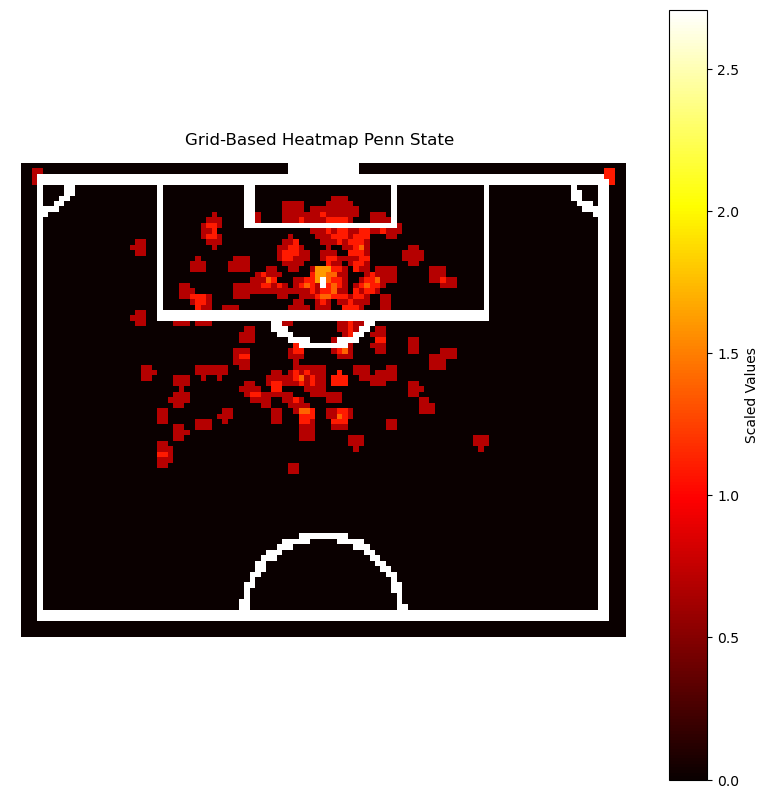

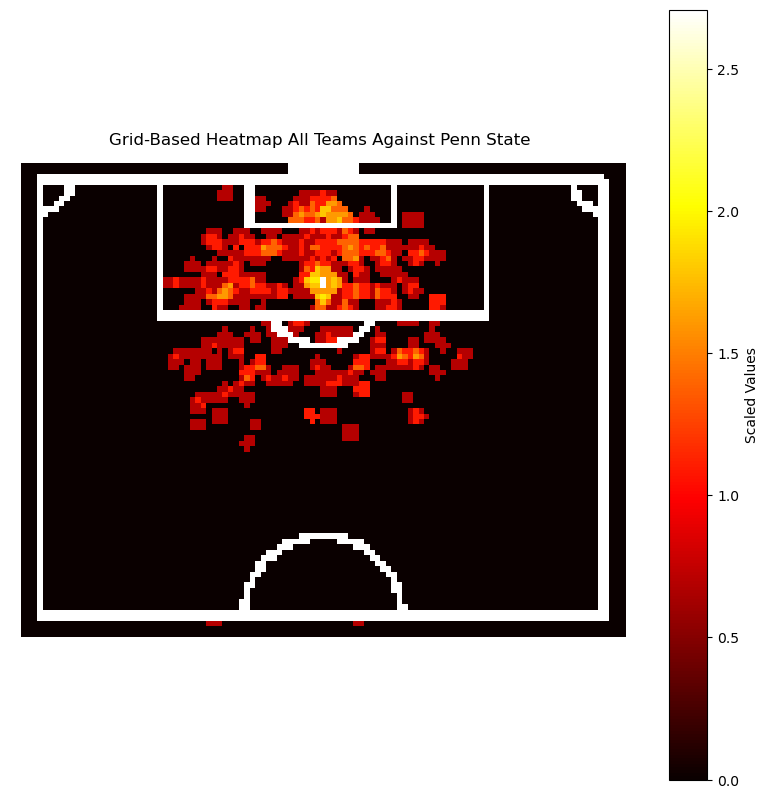

In [5]:
home_heat_map_path = os.path.join(folder_path, "home_team/shooting_map")
# Process the folder and generate the accumulated grid-based mask
home_accumulated_mask = process_folder_with_fixed_pixel_grid(home_heat_map_path, cell_size=(10, 10), threshold_fraction=0.1)

# Ensure the mask is not empty
if home_accumulated_mask is not None:
    # Plot the heatmap
    plot_heatmap(home_accumulated_mask, title=f"Grid-Based Heatmap {team_name}")
else:
    print("No images processed. Please check the folder path and contents.")
    
opp_heat_map_path = os.path.join(folder_path, "opp_team/shooting_map")
# Process the folder and generate the accumulated grid-based mask
opp_accumulated_mask = process_folder_with_fixed_pixel_grid(opp_heat_map_path, cell_size=(10, 10), threshold_fraction=0.1)

# Ensure the mask is not empty
if opp_accumulated_mask is not None:
    # Plot the heatmap
    plot_heatmap(opp_accumulated_mask, title=f"Grid-Based Heatmap All Teams Against {team_name}")
else:
    print("No images processed. Please check the folder path and contents.")
    

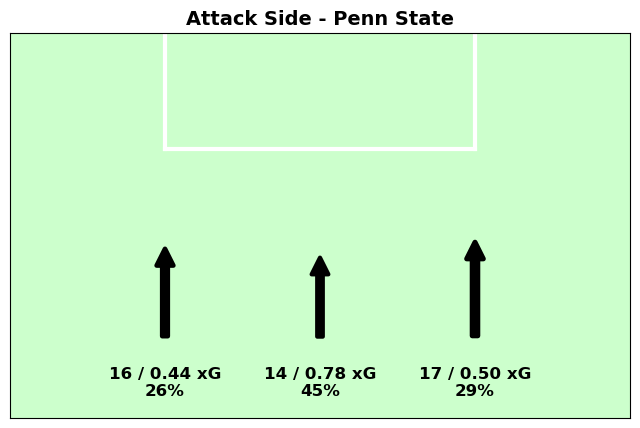

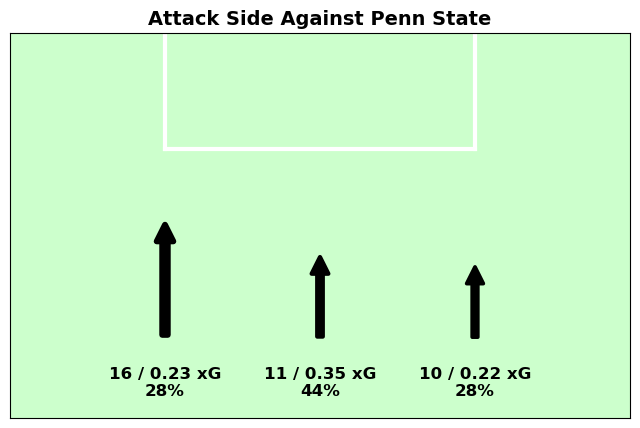

In [6]:
home_attack_side_path = os.path.join(folder_path, "home_team/shooting_side")
home_attack_side = process_folder_attack_side(home_attack_side_path)
opp_attack_side_path = os.path.join(folder_path, "opp_team/shooting_side")
opp_attack_side = process_folder_attack_side(opp_attack_side_path)
plot_attack_side(home_attack_side, title=f"Attack Side - {team_name}")
plot_attack_side(opp_attack_side, title=f"Attack Side Against {team_name}")

In [7]:
avg_formation_path = os.path.join(folder_path, "home_team/avg_formation")
avg_formation = avg_formation_from_folder(avg_formation_path, team_name)

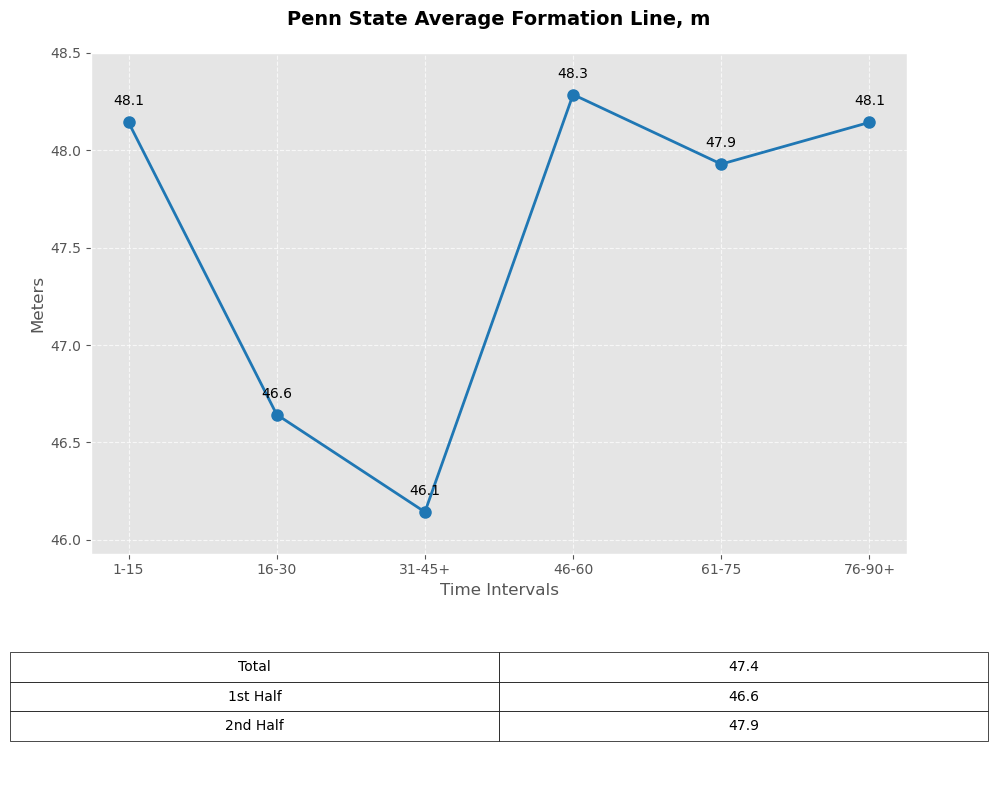

In [8]:
plot_avg_formation(avg_formation, team_name)

In [9]:
team_summary = get_team_data(team_data_path, team_name)
prompt, system_message = generate_prompt(team_summary, home_attack_side, avg_formation)

In [10]:
from dotenv import load_dotenv
load_dotenv()

True

In [12]:
import openai
from openai import OpenAI
openai.api_key = os.environ.get("OPENAI_API_KEY")
client = OpenAI(api_key = openai.api_key)
# Make the API call to ChatGPT
response = client.chat.completions.create(
    model="gpt-4",
    messages=[
        {"role": "system", "content": system_message},
        {"role": "user", "content": prompt},
    ],
    max_tokens=200
)

# Output the analysis from ChatGPT
analysis = response.choices[0].message.content
print(analysis)

Strengths:
1. The Penn State Nittany Lion is quite productive offensively. It has amassed a high number of goals, with almost 1.4 expected goals per game. This indicates that their attacking moves are generally effective and likely to result in goals. They have taken an impressive 794 shots with 305 of them on target which is a good ratio of shots on target. 
2. The pass success rate is quite high, indicating good team coordination and precise passing. 
3. The recoveries and clearances also demonstrate a well-organized and moderately efficient defense.

Weaknesses:
1. Even though the team has a high number of goals, the team's shooting accuracy might be a concern because only a little more than a third of their shots are on target.
2. Even though they are good at recovering the ball, they have a high number of losses. This indicates that they often lose possession of the ball, which could be due to several reasons such as poor


In [13]:
pip install dash plotly

Note: you may need to restart the kernel to use updated packages.


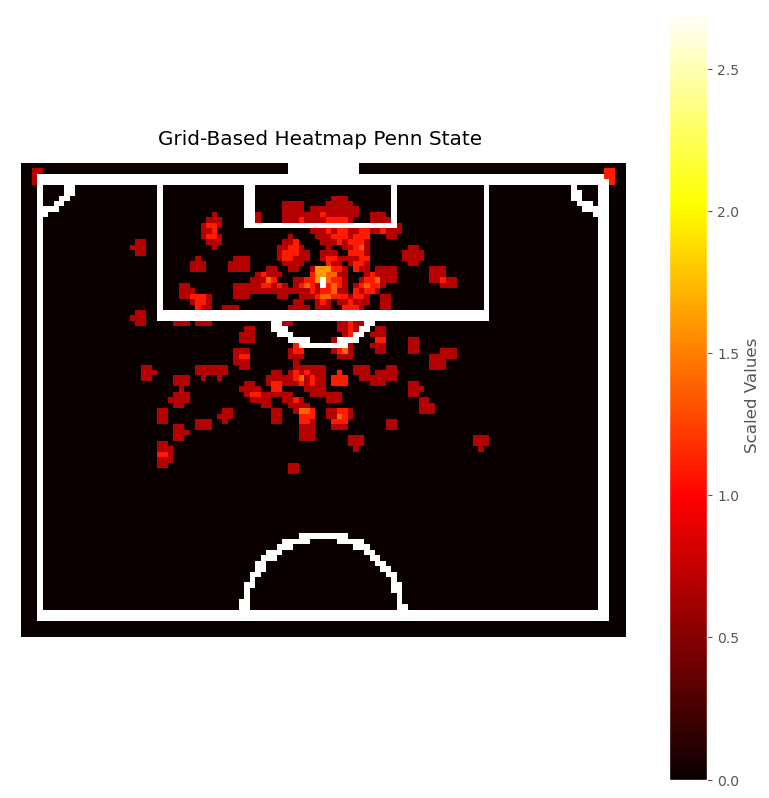

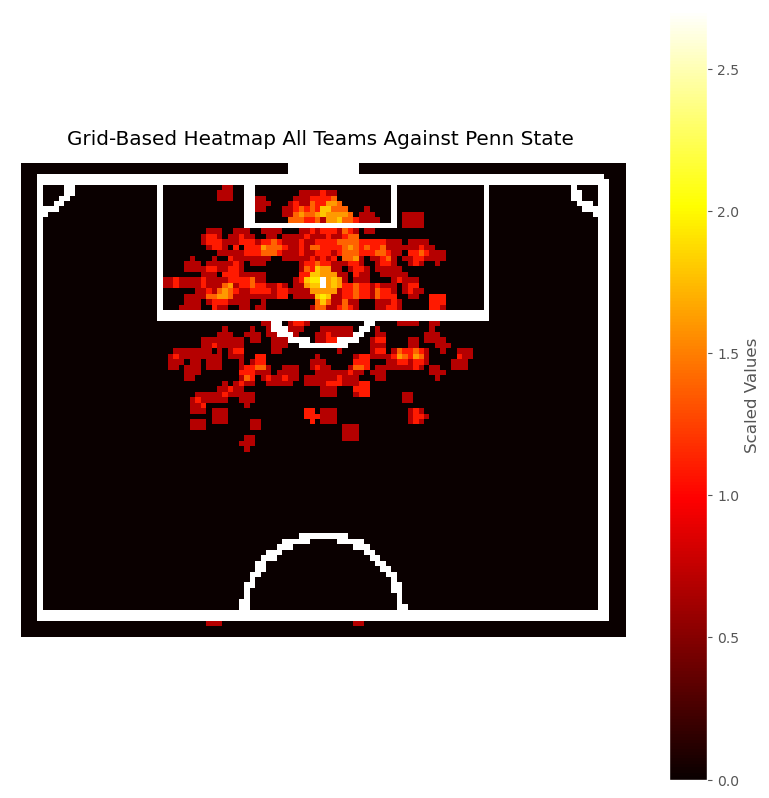

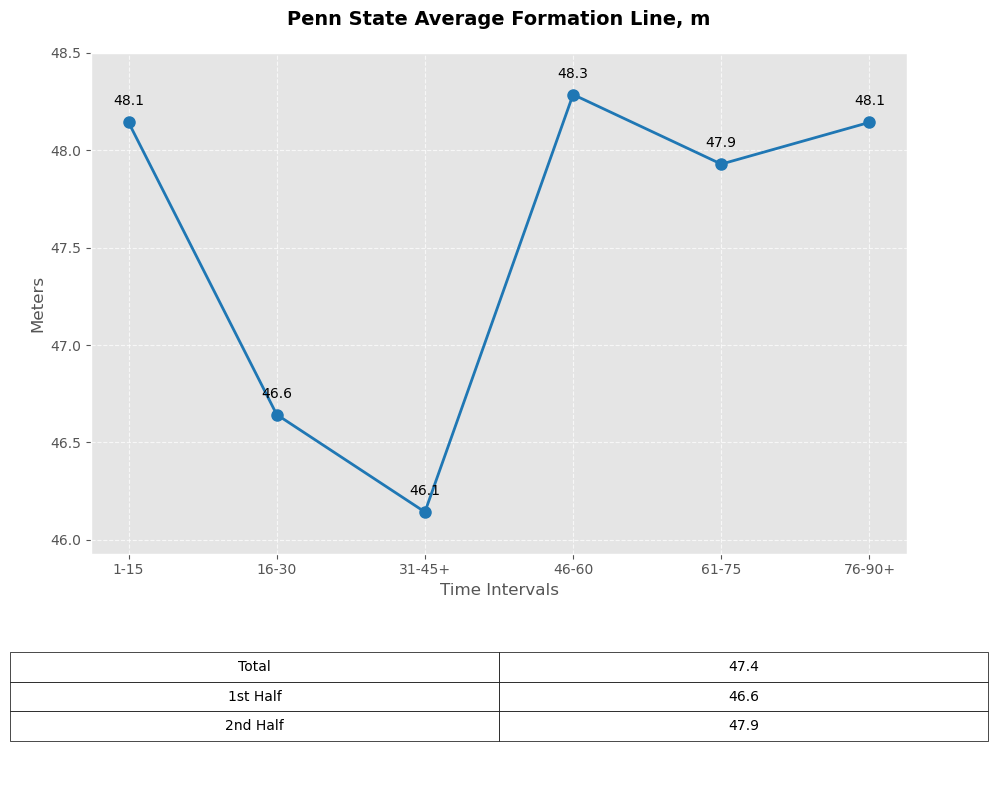

AssertionError: The setup method 'errorhandler' can no longer be called on the application. It has already handled its first request, any changes will not be applied consistently.
Make sure all imports, decorators, functions, etc. needed to set up the application are done before running it.

In [17]:
import dash
from dash import dcc, html
from dash.dependencies import Input, Output
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import io
import base64

# App layout
app.layout = html.Div([
    html.H1(f"Performance Dashboard for {team_name}", style={'textAlign': 'center'}),
    
    # Heatmaps Row
    html.Div([
        html.Div([
            html.H3(f"Grid-Based Heatmap {team_name}"),
            html.Img(src=f"data:image/png;base64,{plot_heatmap(home_accumulated_mask, title=f'Grid-Based Heatmap {team_name}')}", style={'width': '100%', 'height': 'auto'})
        ], className="six columns"),
        
        html.Div([
            html.H3(f"Grid-Based Heatmap All Teams Against {team_name}"),
            html.Img(src=f"data:image/png;base64,{plot_heatmap(opp_accumulated_mask, title=f'Grid-Based Heatmap All Teams Against {team_name}')}", style={'width': '100%', 'height': 'auto'})
        ], className="six columns"),
    ], className="row", style={'display': 'flex', 'justify-content': 'space-between'}),
    
    # Average Formation
    html.Div([
        html.H3(f"Average Formation for {team_name}"),
        html.Img(src=f"data:image/png;base64,{plot_avg_formation(avg_formation, team_name)}", style={'width': '100%', 'height': 'auto'})
    ], style={'margin-top': '20px'}),
    
    # Analysis Section
    html.Div([
        html.H3("Analysis Summary"),
        html.Pre(analysis, style={'white-space': 'pre-wrap', 'word-wrap': 'break-word'})
    ], style={'margin-top': '20px'})
])

# Run the app
if __name__ == '__main__':
    app.run_server(debug=True)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


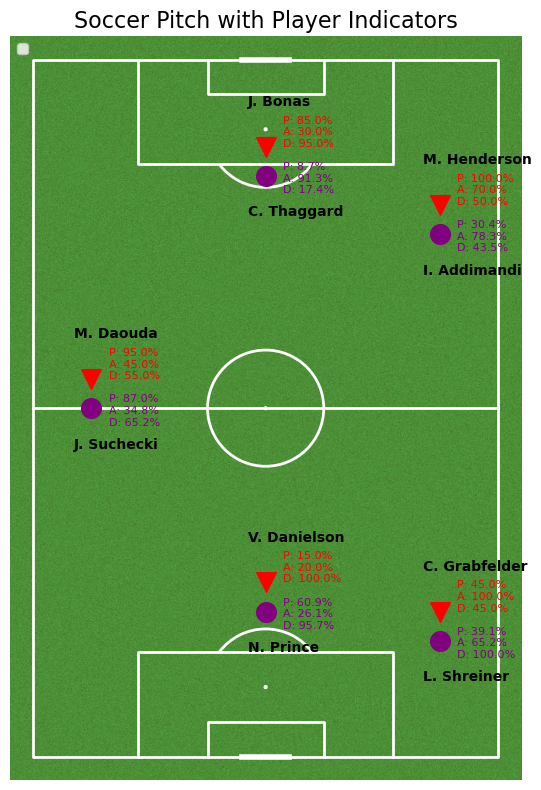

In [11]:
player_df = pd.read_csv(player_data_path)
player_df = player_df[player_df.year == play_year]

other_crucial_player = calculate_weighted_scores(player_df, other_team_name, topk=2)
nu_crucial_player = calculate_weighted_scores(player_df, "Northwestern Wildcats", topk=10)
position_data = get_most_played_position(player_df)

other_crucial_player = other_crucial_player.merge(position_data, on = ['player_name', 'team'], how = 'left')
nu_crucial_player = nu_crucial_player.merge(position_data, on = ['player_name', 'team'], how = 'left')

nu_crucial_player.drop_duplicates(inplace= True)
other_crucial_player.drop_duplicates(inplace= True)

matches_df = get_opponent(other_crucial_player, nu_crucial_player)

other_crucial_player_info = other_crucial_player[["player_name", "team", "defensive_percentile", "attacking_percentile", "passing_percentile"]]
nu_crucial_player_info = nu_crucial_player[["player_name", "team", "defensive_percentile", "attacking_percentile", "passing_percentile"]].drop_duplicates()
matches_df_with_ohio = matches_df.merge(other_crucial_player_info, left_on = ["Crucial Player Name", "Crucial Player Team"], right_on = ["player_name", "team"], how = 'left').drop(["player_name", "team"], axis = 1)
matches_df_final = matches_df_with_ohio.merge(nu_crucial_player_info, left_on = ["Opponent Player Name", "Opponent Player Team"], right_on = ["player_name", "team"], how = 'inner').drop(["player_name", "team"], axis = 1)
plot_pitch_from_dataframe(matches_df_final)

,Crucial Player Name,Crucial Player Team,Opponent Player Name,Opponent Player Team,Opponent Player Position,defensive_percentile_x,attacking_percentile_x,passing_percentile_x,defensive_percentile_y,attacking_percentile_y,passing_percentile_y
0,V. Danielson,Penn State Nittany Lion,N. Prince,Northwestern Wildcats,CB,1.00,0.20,0.15,0.956522,0.260870,0.608696
1,C. Oliver,Penn State Nittany Lion,N. Prince,Northwestern Wildcats,CB,0.25,0.95,0.25,0.956522,0.260870,0.608696
2,J. Bonas,Penn State Nittany Lion,C. Thaggard,Northwestern Wildcats,CF,0.95,0.30,0.85,0.173913,0.913043,0.086957
3,C. Grabfelder,Penn State Nittany Lion,L. Shreiner,Northwestern Wildcats,RB,0.45,1.00,0.45,1.000000,0.652174,0.391304
4,M. Henderson,Penn State Nittany Lion,I. Addimandi,Northwestern Wildcats,RW,0.50,0.70,1.00,0.434783,0.782609,0.304348
5,M. Daouda,Penn State Nittany Lion,J. Suchecki,Northwestern Wildcats,LCM,0.55,0.45,0.95,0.652174,0.347826,0.869565
